In [276]:
import numpy as np
import threading
import queue
import time
import matplotlib.pyplot as plt
from datetime import date

In [238]:
def simple_NMF(a, k, i):
    m, n = np.shape(a)
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)
    for _ in range(i):
        w = w * (a @ h.T) / (w @ h @ h.T)
        h = h * (w.T @ a) / (w.T @ w @ h)
    return w @ h

simple_NMF(np.identity(8)+1, 8, 1000)

array([[2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 1., 1., 2.]])

In [244]:
def thread_function_w(a, w, h, q, i):
    q.put((i, w * (a @ h.T) / (w @ h @ h.T)))

def thread_function_h(a, w, h, q, i):
    q.put((i, h * (w.T @ a) / (w.T @ w @ h)))

def naive_parallel_NMF(a, k, p, numIter):
    m, n = np.shape(a)
    if m % p > 0:
        raise TypeError('Input first dimension not divisible by number of threads')
    if n % p > 0:
        raise TypeError('Input second dimension not divisible by number of threads')
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)
    a_pieces_1 = np.split(a, p, 0) # cut a into p pieces of shape m/p x n
    assert np.shape(a_pieces_1[0]) == (int(m/p), n)
    a_pieces_2 = np.split(a, p, 1) # cut a into p pieces of shape m x n/p
    assert np.shape(a_pieces_2[0]) == (m, int(n/p))
    
    for _ in range(numIter):
        w_pieces = np.split(w, p, 0) # cut w into p pieces of shape m/p x n
        assert np.shape(w_pieces[0]) == (int(m/p), k)
        w_threads = []
        w_queue = queue.Queue()
        for j in range(p): # split into p threads to calculate updates for each piece
            newThread = threading.Thread(target = thread_function_w, args = (a_pieces_1[j], w_pieces[j], h, w_queue, j))
            newThread.start()
            w_threads.append(newThread)
        for thread in w_threads: # wait for all threads to complete
            thread.join()
        while not w_queue.empty(): # reconstitute and update w
            i, val = w_queue.get()
            w_pieces[i] = val
        w = np.concatenate(w_pieces, 0)

        h_pieces = np.split(h, p, 1) # cut h into p pieces of shape m x n/p
        assert np.shape(h_pieces[0]) == (k, int(n/p))
        h_threads = []
        h_queue = queue.Queue()
        for j in range(p): # split into p threads to calculate updates for each piece
            newThread = threading.Thread(target = thread_function_h, args = (a_pieces_2[j], w, h_pieces[j], h_queue, j))
            newThread.start()
            h_threads.append(newThread)
        for thread in h_threads: # wait for all threads to complete
            thread.join()
        while not h_queue.empty(): # reconstitute and update h
            i, val = h_queue.get()
            h_pieces[i] = val
        h = np.concatenate(h_pieces, 1)
    return w @ h
    
#naive_parallel_NMF(np.identity(8)+1, 8, 4, 1000)

In [240]:
def vertical_thread_function_u(h, q):
    q.put(h @ h.T)

def vertical_thread_function_v(a, h, q, i):
    q.put((i, a @ h.T))

def vertical_thread_function_w(w, u, y, q, i):
    q.put((i, w * y / (w @ u)))

def vertical_thread_function_x(w, q):
    q.put(w.T @ w)

def vertical_thread_function_y(a, w, q, i):
    q.put((i, w.T @ a))

def vertical_thread_function_h(h, x, y, q, i):
    q.put((i, h * y / (x @ h)))

def vertical_HPC_NMF(a, k, p_row, p_col, numIter):
    m, n = np.shape(a)
    if m % (p_row*p_col) > 0:
        raise TypeError('Input first dimension not divisible by number of threads')
    if n % (p_row*p_col) > 0:
        raise TypeError('Input second dimension not divisible by number of threads')
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)

    a_pieces = [np.split(x, p_col, 1) for x in np.split(a, p_row, 0)] # cut a into p_row x p_col pieces of shape m/p_row x n/p_col
    assert np.shape(a_pieces[0][0]) == (int(m/p_row), int(n/p_col))

    for _ in range(numIter):
        u = np.zeros((k, k))
        h_pieces_u = np.split(h, p_row*p_col, 1) # cut h into p_row*p_col pieces of shape k x n/(p_row*p_col)
        assert np.shape(h_pieces_u[0]) == (k, int(n/(p_row*p_col)))
        threads_u = []
        queue_u = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate u for each piece
            newThread = threading.Thread(target = vertical_thread_function_u, args = (h_pieces_u[i], queue_u))
            newThread.start()
            threads_u.append(newThread)
        for thread in threads_u: # wait for all threads to complete
            thread.join()
        while not queue_u.empty(): # sum up u
            u += queue_u.get()
        assert np.all(np.isclose(u, h @ h.T))       

        v = np.zeros((m, k))
        v_pieces = np.split(v, p_row, 0) # cut v into p_row pieces of shape m/p_row x k
        assert np.shape(v_pieces[0]) == (int(m/p_row), k)
        h_pieces_v = np.split(h, p_col, 1) # cut h into p_col pieces of shape k x n/p_col
        assert np.shape(h_pieces_v[0]) == (k, int(n/p_col))
        threads_v = []
        queue_v = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_v, args = (a_pieces[int(i/p_col)][i%p_col], h_pieces_v[i%p_col], queue_v, i))
            newThread.start()
            threads_v.append(newThread)
        for thread in threads_v: # wait for all threads to complete
            thread.join()
        while not queue_v.empty(): # sum up v
            i, val = queue_v.get()
            v_pieces[int(i/p_col)] += val
        v = np.concatenate(v_pieces, 0)
        assert np.all(np.isclose(v, a @ h.T))
        
        w_pieces = np.split(w, p_row*p_col, 0) # cut w into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(w_pieces[0]) == (m/(p_row*p_col), k)
        v_pieces_w = np.split(v, p_row*p_col, 0) # cut v into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(v_pieces_w[0]) == (m/(p_row*p_col), k)
        threads_w = []
        queue_w = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_w, args = (w_pieces[i], u, v_pieces_w[i], queue_w, i))
            newThread.start()
            threads_w.append(newThread)
        for thread in threads_w: # wait for all threads to complete
            thread.join()
        while not queue_w.empty(): # sum up u
            i, val = queue_w.get()
            w_pieces[i] = val
        w = np.concatenate(w_pieces, 0)
        
        x = np.zeros((k, k))
        w_pieces_x = np.split(w, p_row*p_col, 0) # cut x into p_row*p_col pieces of shape n/(p_row*p_col) x k
        assert np.shape(w_pieces_x[0]) == (int(n/(p_row*p_col)), k)
        threads_x = []
        queue_x = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate u for each piece
            newThread = threading.Thread(target = vertical_thread_function_x, args = (w_pieces_x[i], queue_x))
            newThread.start()
            threads_x.append(newThread)
        for thread in threads_x: # wait for all threads to complete
            thread.join()
        while not queue_x.empty(): # sum up x
            x += queue_x.get()
        assert np.all(np.isclose(x, w.T @ w))

        y = np.zeros((k, n))
        y_pieces = np.split(y, p_col, 1) # cut y into p_col pieces of shape k x n/p_col
        assert np.shape(y_pieces[0]) == (k, int(n/p_col))
        w_pieces_y = np.split(w, p_row, 0) # cut w into p_row pieces of shape m/p_row x k
        assert np.shape(w_pieces_y[0]) == (int(m/p_row), k)
        threads_y = []
        queue_y = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_y, args = (a_pieces[i%p_row][int(i/p_row)], w_pieces_y[i%p_row], queue_y, i))
            newThread.start()
            threads_y.append(newThread)
        for thread in threads_y: # wait for all threads to complete
            thread.join()
        while not queue_y.empty(): # sum up y
            i, val = queue_y.get()
            y_pieces[int(i/p_row)] += val
        y = np.concatenate(y_pieces, 1)
        assert np.all(np.isclose(y, w.T @ a))

        h_pieces = np.split(h, p_row*p_col, 1) # cut h into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(h_pieces[0]) == (k, int(n/(p_row*p_col)))
        y_pieces_h = np.split(y, p_row*p_col, 1) # cut y into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(y_pieces_h[0]) == (k, int(n/(p_row*p_col)))
        threads_h = []
        queue_h = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_h, args = (h_pieces[i], x, y_pieces_h[i], queue_h, i))
            newThread.start()
            threads_h.append(newThread)
        for thread in threads_h: # wait for all threads to complete
            thread.join()
        while not queue_h.empty(): # sum up u
            i, val = queue_h.get()
            h_pieces[i] = val
        h = np.concatenate(h_pieces, 1)        
    return w @ h

vertical_HPC_NMF(np.identity(8)+1, 8, 4, 2, 1000)

array([[2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 1., 1., 2.]])

In [267]:
def timingFunc(func, args, iterations):
    times = []
    for _ in range(iterations):
        start = time.perf_counter()
        func(*args)
        times.append(time.perf_counter()-start)
    return np.mean(times)

k = 4
p0 = 2
p1 = 2
iter = 100
points = 10
sizes = range(5)
simple = [timingFunc(simple_NMF, (np.identity(4*i)+1, k, iter), points) for i in sizes]
naive = [timingFunc(naive_parallel_NMF, (np.identity(4*i)+1, k, p0*p1, iter), points) for i in sizes]
vertical = [timingFunc(vertical_HPC_NMF, (np.identity(4*i)+1, k, p0, p1, iter), points) for i in sizes]

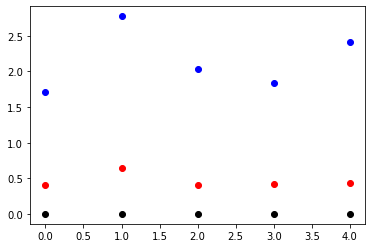

In [270]:
plt.plot(simple, 'ko')
plt.plot(naive, 'ro')
plt.plot(vertical, 'bo')
plt.show()

Next, we will optimize both the number of processor dimensions (p) and the rank of the factorization (k). For each, we will optimize runtime, minimize computing costs, bandwith cost(?), and communication cost (?). We will examine these results on both dense and sparse imput matricies (A)(?). For each set, the study fixes the number of processors at 600 and vary the rank of k. We will replicate this, but also try to optimize the number of processors for our dataset.

Note** we need to find datasets; preferably one sparse and one dense dataset, or we could generate synthetic sparse and dense datasets.



In [10]:
c4 = pd.read_csv('c4_game_database.csv')
c4[c4 < 0] = 2 #changing -1 values to 2
c4
#really not sure if this works for a sparse dataset but wanted to start exploring

,pos_01,pos_02,pos_03,pos_04,pos_05,pos_06,pos_07,pos_08,pos_09,pos_10,...,pos_34,pos_35,pos_36,pos_37,pos_38,pos_39,pos_40,pos_41,pos_42,winner
0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,2.0,2.0,2.0,...,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,2.0
4,0.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376635,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0
376636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,2.0
376637,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0
376638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0


In [25]:
class NMF_Base(object):

    """ Base class for NMF algorithms
    Specific algorithms need to be implemented by deriving from this class.
    """
    default_max_iter = 100
    default_max_time = np.inf

    def __init__(self):
        raise NotImplementedError(
            'NMF_Base is a base class that cannot be instantiated')

    def set_default(self, default_max_iter, default_max_time):
        self.default_max_iter = default_max_iter
        self.default_max_time = default_max_time

    def run(self, A, k, init=None, max_iter=None, max_time=None, verbose=0):
        """ Run a NMF algorithm
        Parameters
        ----------
        A : numpy.array or scipy.sparse matrix, shape (m,n)
        k : int - target lower rank
        Optional Parameters
        -------------------
        init : (W_init, H_init) where
                    W_init is numpy.array of shape (m,k) and
                    H_init is numpy.array of shape (n,k).
                    If provided, these values are used as initial values for NMF iterations.
        max_iter : int - maximum number of iterations.
                    If not provided, default maximum for each algorithm is used.
        max_time : int - maximum amount of time in seconds.
                    If not provided, default maximum for each algorithm is used.
        verbose : int - 0 (default) - No debugging information is collected, but
                                    input and output information is printed on screen.
                        -1 - No debugging information is collected, and
                                    nothing is printed on screen.
                        1 (debugging/experimental purpose) - History of computation is
                                        returned. See 'rec' variable.
                        2 (debugging/experimental purpose) - History of computation is
                                        additionally printed on screen.
        Returns
        -------
        (W, H, rec)
        W : Obtained factor matrix, shape (m,k)
        H : Obtained coefficient matrix, shape (n,k)
        rec : dict - (debugging/experimental purpose) Auxiliary information about the execution
        """
        info = {'k': k,
                'alg': str(self.__class__),
                'A_dim_1': A.shape[0],
                'A_dim_2': A.shape[1],
                'A_type': str(A.__class__),
                'max_iter': max_iter if max_iter is not None else self.default_max_iter,
                'verbose': verbose,
                'max_time': max_time if max_time is not None else self.default_max_time}
        if init != None:
            W = init[0].copy()
            H = init[1].copy()
            info['init'] = 'user_provided'
        else:
            W = random.rand(A.shape[0], k)
            H = random.rand(A.shape[1], k)
            info['init'] = 'uniform_random'

        if verbose >= 0:
            print ('[NMF] Running: ')
            print (json.dumps(info, indent=4, sort_keys=True))

        norm_A = mu.norm_fro(A)
        total_time = 0

        if verbose >= 1:
            his = {'iter': [], 'elapsed': [], 'rel_error': []}

        start = time.time()
        # algorithm-specific initilization
        (W, H) = self.initializer(W, H)

        for i in range(1, info['max_iter'] + 1):
            start_iter = time.time()
            # algorithm-specific iteration solver
            (W, H) = self.iter_solver(A, W, H, k, i)
            elapsed = time.time() - start_iter

            if verbose >= 1:
                rel_error = mu.norm_fro_err(A, W, H, norm_A) / norm_A
                his['iter'].append(i)
                his['elapsed'].append(elapsed)
                his['rel_error'].append(rel_error)
                if verbose >= 2:
                    print ('iter:' + str(i) + ', elapsed:' + str(elapsed) + ', rel_error:' + str(rel_error))

            total_time += elapsed
            if total_time > info['max_time']:
                break

        W, H, weights = mu.normalize_column_pair(W, H)

        final = {}
        final['norm_A'] = norm_A
        final['rel_error'] = mu.norm_fro_err(A, W, H, norm_A) / norm_A
        final['iterations'] = i
        final['elapsed'] = time.time() - start

        rec = {'info': info, 'final': final}
        if verbose >= 1:
            rec['his'] = his

        if verbose >= 0:
            print ('[NMF] Completed: ')
            print (json.dumps(final, indent=4, sort_keys=True))
        return (W, H, rec)

    def run_repeat(self, A, k, num_trial, max_iter=None, max_time=None, verbose=0):
        """ Run an NMF algorithm several times with random initial values 
            and return the best result in terms of the Frobenius norm of
            the approximation error matrix
        Parameters
        ----------
        A : numpy.array or scipy.sparse matrix, shape (m,n)
        k : int - target lower rank
        num_trial : int number of trials
        Optional Parameters
        -------------------
        max_iter : int - maximum number of iterations for each trial.
                    If not provided, default maximum for each algorithm is used.
        max_time : int - maximum amount of time in seconds for each trial.
                    If not provided, default maximum for each algorithm is used.
        verbose : int - 0 (default) - No debugging information is collected, but
                                    input and output information is printed on screen.
                        -1 - No debugging information is collected, and
                                    nothing is printed on screen.
                        1 (debugging/experimental purpose) - History of computation is
                                        returned. See 'rec' variable.
                        2 (debugging/experimental purpose) - History of computation is
                                        additionally printed on screen.
        Returns
        -------
        (W, H, rec)
        W : Obtained factor matrix, shape (m,k)
        H : Obtained coefficient matrix, shape (n,k)
        rec : dict - (debugging/experimental purpose) Auxiliary information about the execution
        """
        for t in iter(range(num_trial)):
            if verbose >= 0:
                print ('[NMF] Running the {0}/{1}-th trial ...'.format(t + 1, num_trial))
            this = self.run(A, k, verbose=(-1 if verbose is 0 else verbose))
            if t == 0:
                best = this
            else:
                if this[2]['final']['rel_error'] < best[2]['final']['rel_error']:
                    best = this
        if verbose >= 0:
            print ('[NMF] Best result is as follows.')
            print (json.dumps(best[2]['final'], indent=4, sort_keys=True))
        return best

    def iter_solver(self, A, W, H, k, it):
        raise NotImplementedError

    def initializer(self, W, H):
        return (W, H)

<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/xf/8808rrps3wb3r170fzcq_6t00000gn/T/ipykernel_57360/2333205815.py:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
  this = self.run(A, k, verbose=(-1 if verbose is 0 else verbose))


In [26]:
import scipy.sparse as sps
import scipy.optimize as opt
import numpy.linalg as nla
from nonnegfac import matrix_utils as mu
import time
import json
from numpy import random
from nonnegfac.nnls import nnlsm_activeset
from nonnegfac.nnls import nnlsm_blockpivot
class NMF_HALS(NMF_Base):

    """ NMF algorithm: Hierarchical alternating least squares
    A. Cichocki and A.-H. Phan, Fast local algorithms for large scale nonnegative matrix and tensor factorizations,
    IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences,
    vol. E92-A, no. 3, pp. 708-721, 2009.
    """

    def __init__(self, default_max_iter=100, default_max_time=np.inf):
        self.eps = 1e-16
        self.set_default(default_max_iter, default_max_time)

    def initializer(self, W, H):
        W, H, weights = mu.normalize_column_pair(W, H)
        return W, H

    def iter_solver(self, A, W, H, k, it):
        AtW = A.T.dot(W)
        WtW = W.T.dot(W)
        for kk in iter(range(0, k)):
            temp_vec = H[:, kk] + AtW[:, kk] - H.dot(WtW[:, kk])
            H[:, kk] = np.maximum(temp_vec, self.eps)

        AH = A.dot(H)
        HtH = H.T.dot(H)
        for kk in iter(range(0, k)):
            temp_vec = W[:, kk] * HtH[kk, kk] + AH[:, kk] - W.dot(HtH[:, kk])
            W[:, kk] = np.maximum(temp_vec, self.eps)
            ss = nla.norm(W[:, kk])
            if ss > 0:
                W[:, kk] = W[:, kk] / ss

        return (W, H)